# 線形判別分析（LDA）

### データの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)
df_wine.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


### データの標準化

In [3]:
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### クラスごとの平均ベクトル  
例えば、クラスAの各特徴量毎の平均値のあつまり、がこれにあたる

In [6]:
np.set_printoptions(precision=4)
mean_vecs=[]
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV{}: {}'.format(label, mean_vecs))

MV1: [array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
       -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075])]
MV2: [array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
       -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]), array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
       -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253])]
MV3: [array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
       -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]), array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
       -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253]), array([ 0.1992,  0.866 ,  0.1682,  0.4148, -0.0451, -1.0286, -1.2876,
        0.8287, -0.7795,  0.9649, -1.209 , -1.3622, -0.4013])]


クラス内変動行列を計算する

In [8]:
d = 13
S_W = np.zeros((d, d))
S_W

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix: {}x{}'.format(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


変動行列を計算するときの前提条件として  
クラスラベルが一様に分布していることが必要

In [10]:
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))

Class label distribution: [41 50 33]


分布していないから、スケーリングする

In [11]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

In [12]:
S_W

array([[ 1.2448,  0.0967, -0.1276, -0.1105, -0.0726,  0.2374,  0.0753,
         0.0231,  0.1102,  0.4261,  0.1411, -0.0155,  0.1224],
       [ 0.0967,  2.2666,  0.1168,  0.3517, -0.2622, -0.0467, -0.0186,
         0.2194,  0.0187, -0.3939, -0.4167,  0.0787, -0.2492],
       [-0.1276,  0.1168,  2.6024,  1.6442,  0.5364,  0.3947,  0.3191,
         0.4553, -0.0353,  0.06  ,  0.167 ,  0.1987, -0.0081],
       [-0.1105,  0.3517,  1.6442,  2.1604,  0.325 ,  0.1535,  0.1222,
         0.273 , -0.0824, -0.068 ,  0.0336,  0.2548, -0.1201],
       [-0.0726, -0.2622,  0.5364,  0.325 ,  2.4397,  0.2384,  0.1433,
        -0.5166,  0.2566,  0.1445,  0.1777, -0.0058,  0.2509],
       [ 0.2374, -0.0467,  0.3947,  0.1535,  0.2384,  1.352 ,  0.6416,
        -0.0781,  0.7644,  0.4392,  0.0177,  0.4359,  0.1554],
       [ 0.0753, -0.0186,  0.3191,  0.1222,  0.1433,  0.6416,  0.6968,
        -0.2588,  0.5765,  0.3851, -0.0408,  0.2525,  0.0748],
       [ 0.0231,  0.2194,  0.4553,  0.273 , -0.5166, -0.0781, 

クラス間変動行列を求める

In [17]:
# 全データの各特徴量平均
mean_overall = np.mean(X_train_std, axis=0)

d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    # 各クラスのデータが何個あるか
    n = X_train[y_train == i + 1, :].shape[0]
    
    # 列ベクトルを生成
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: {}x{}'.format(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


新しい特徴部分空間の線形判別（軸）を選択する

In [18]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [22]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs

[(0.0, array([ 0.7517+0.j, -0.0834+0.j, -0.2406+0.j,  0.2515+0.j, -0.0586+0.j,
          0.1027+0.j,  0.0109+0.j, -0.025 +0.j,  0.0611+0.j, -0.0726+0.j,
          0.1757+0.j, -0.0943+0.j, -0.4933+0.j])),
 (172.76152218979388,
  array([-0.4092+0.j, -0.1577+0.j, -0.3537+0.j,  0.3223+0.j, -0.0817+0.j,
          0.0842+0.j,  0.2823+0.j, -0.0102+0.j,  0.0907+0.j, -0.2152+0.j,
          0.2747+0.j, -0.0124+0.j, -0.5958+0.j])),
 (349.6178089059939,
  array([-0.1481+0.j,  0.0908+0.j, -0.0168+0.j,  0.1484+0.j, -0.0163+0.j,
          0.1913+0.j, -0.7338+0.j, -0.075 +0.j,  0.0018+0.j,  0.294 +0.j,
         -0.0328+0.j, -0.3547+0.j, -0.3915+0.j])),
 (3.7853134512521556e-14,
  array([ 0.406 +0.j,  0.153 +0.j,  0.2157+0.j,  0.1153+0.j,  0.0043+0.j,
         -0.038 +0.j, -0.5208+0.j, -0.0864+0.j,  0.1421+0.j, -0.0811+0.j,
         -0.0103+0.j,  0.6254+0.j, -0.2319+0.j])),
 (2.117398448224407e-14,
  array([-0.5115+0.j, -0.1468+0.j,  0.0056+0.j, -0.1081+0.j, -0.1021+0.j,
          0.2103+0.j, -0.1468+0

In [25]:
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


# sklearnでLDAを実装してみる

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


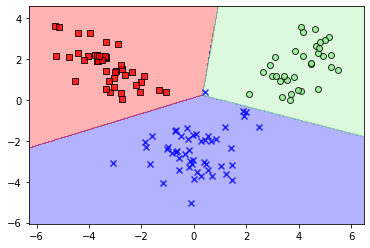

In [11]:
from plot_decision_regions import plot_decision_regions

plot_decision_regions(X_train_lda, y_train, classifier=lr)

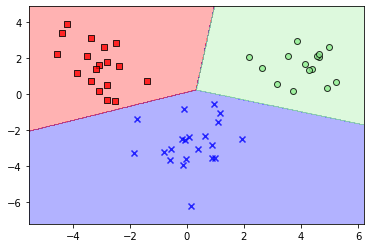

In [12]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)